In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2
import random

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/xray/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Mounted at /content/drive


In [4]:
import shutil
shutil.copy('/content/drive/Shareddrives/CV/cnn/test.zip', 'test.zip')
shutil.copy('/content/drive/Shareddrives/CV/cnn/train.zip', 'train.zip')
!unzip test.zip
!unzip train.zip
shutil.copy('/content/drive/Shareddrives/CV/cnn/test.csv', 'test.csv')
shutil.copy('/content/drive/Shareddrives/CV/cnn/train.csv', 'train.csv')

Streaming output truncated to the last 5000 lines.
  inflating: train/cnn5008.data      
  inflating: train/cnn5009.data      
  inflating: train/cnn501.data       
  inflating: train/cnn5010.data      
  inflating: train/cnn5011.data      
  inflating: train/cnn5013.data      
  inflating: train/cnn5014.data      
  inflating: train/cnn5015.data      
  inflating: train/cnn5016.data      
  inflating: train/cnn5017.data      
  inflating: train/cnn5018.data      
  inflating: train/cnn5019.data      
  inflating: train/cnn502.data       
  inflating: train/cnn5021.data      
  inflating: train/cnn5022.data      
  inflating: train/cnn5023.data      
  inflating: train/cnn5024.data      
  inflating: train/cnn5025.data      
  inflating: train/cnn5027.data      
  inflating: train/cnn5029.data      
  inflating: train/cnn503.data       
  inflating: train/cnn5030.data      
  inflating: train/cnn5031.data      
  inflating: train/cnn5032.data      
  inflating: train/cnn5033.data      

'train.csv'

In [5]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

def accuracy(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='valid')

In [6]:
class XRayCNNDataset3Channel(Dataset):
    # root_dir example: r'D:xray/cnn/train'
    # annotation_file example: r'train.csv'
    def __init__(self, root_dir, annotation_file):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        file_name = self.annotations._get_value(index, 'image_id')
        label = self.annotations._get_value(index, 'class_id')
        file = open(os.path.join(self.root_dir, file_name), 'rb')
        img = pickle.load(file)
        file.close()
        img = img.astype('float32')
        img = cv2.resize(img, (300, 300))
        img = np.array([img.copy(), img.copy(), img.copy()])
        return (img, label)

In [7]:
def get_data(batch_size=128):
    trainset = XRayCNNDataset3Channel('/content/train/', '/content/train.csv')
    trainloader  = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    
    testset = XRayCNNDataset3Channel('/content/test/', '/content/test.csv')
    testloader  = DataLoader(testset, batch_size=batch_size, shuffle=False)
    
    classes = ['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly',
               'Consolidation', 'ILD', 'Inflitration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion',
               'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']
    return {'train': trainloader, 'test': testloader, 'classes': classes}

data = get_data()

In [ ]:
print(iter(data['train']).next())

In [8]:
inception_v3 = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
inception_v3.fc = nn.Linear(2048, 14)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


[0,    10] loss: 0.589
[0,    20] loss: 0.605
[0,    30] loss: 0.570
[0,    40] loss: 0.587
[0,    50] loss: 0.591
[0,    60] loss: 0.614
[0,    70] loss: 0.570
[0,    80] loss: 0.603
[0,    90] loss: 0.595
[0,   100] loss: 0.567
[0,   110] loss: 0.562
[0,   120] loss: 0.611
[0,   130] loss: 0.585
[0,   140] loss: 0.581
[0,   150] loss: 0.567
[0,   160] loss: 0.647
[0,   170] loss: 0.637
[0,   180] loss: 0.619
[0,   190] loss: 0.589
[0,   200] loss: 0.590
[0,   210] loss: 0.543
[0,   220] loss: 0.585
[0,   230] loss: 0.605
[0,   240] loss: 0.587
[0,   250] loss: 0.586
[1,    10] loss: 0.596
[1,    20] loss: 0.504
[1,    30] loss: 0.519
[1,    40] loss: 0.540
[1,    50] loss: 0.523
[1,    60] loss: 0.493
[1,    70] loss: 0.527
[1,    80] loss: 0.493
[1,    90] loss: 0.545
[1,   100] loss: 0.508
[1,   110] loss: 0.547
[1,   120] loss: 0.561
[1,   130] loss: 0.562
[1,   140] loss: 0.542
[1,   150] loss: 0.536
[1,   160] loss: 0.541
[1,   170] loss: 0.583
[1,   180] loss: 0.547
[1,   190] 

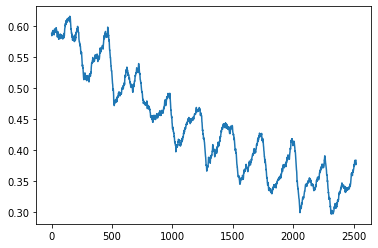

In [12]:
inception_v3.aux_logits = False
losses = train(inception_v3, data['train'], epochs=10, lr=0.001, print_every=10, decay=0.0005, checkpoint_path=checkpoints)
plt.plot(smooth(losses,50))
print('Train accuracy =', accuracy(inception_v3, data['train']))
print('Test accuracy =', accuracy(inception_v3, data['test']))